In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.processing import phase_preprocess
from deepcell.applications import MultiplexSegmentation

In [2]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img, :, :], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [2]:
# create psuedo labels
app = MultiplexSegmentation(use_pretrained_weights=False)
weights = "/data/models/20200619_production_updates/20200802_all_data_512x512_compartment_deep_watershed.h5"
app.model.load_weights(weights)

W0817 17:01:43.631780 139630202242880 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [3]:
original_data = np.load('/data/npz_data/20200816_all_data_normalized_512x512.npz')
X_data, y_data_cell = original_data['X'], original_data['y']
print(X_data.shape, X_data.dtype, y_data_cell.shape, y_data_cell.dtype)

(2546, 512, 512, 2) float16 (2546, 512, 512, 1) int16


In [10]:
predictions7 = app.predict(X_data[2400:], compartment='nuclear',
                           postprocess_kwargs_nuclear={'interior_threshold': 0.6,
                                                         'interior_model_smooth': 0,
                                                         'maxima_model_smooth': 0,
                                                         'maxima_threshold': 0.1})

In [12]:
RGB_data = make_color_overlay(X_data[:10])

In [41]:
predicted_overlay = make_outline_overlay(RGB_data[:10], predictions3[:10, ..., 0])

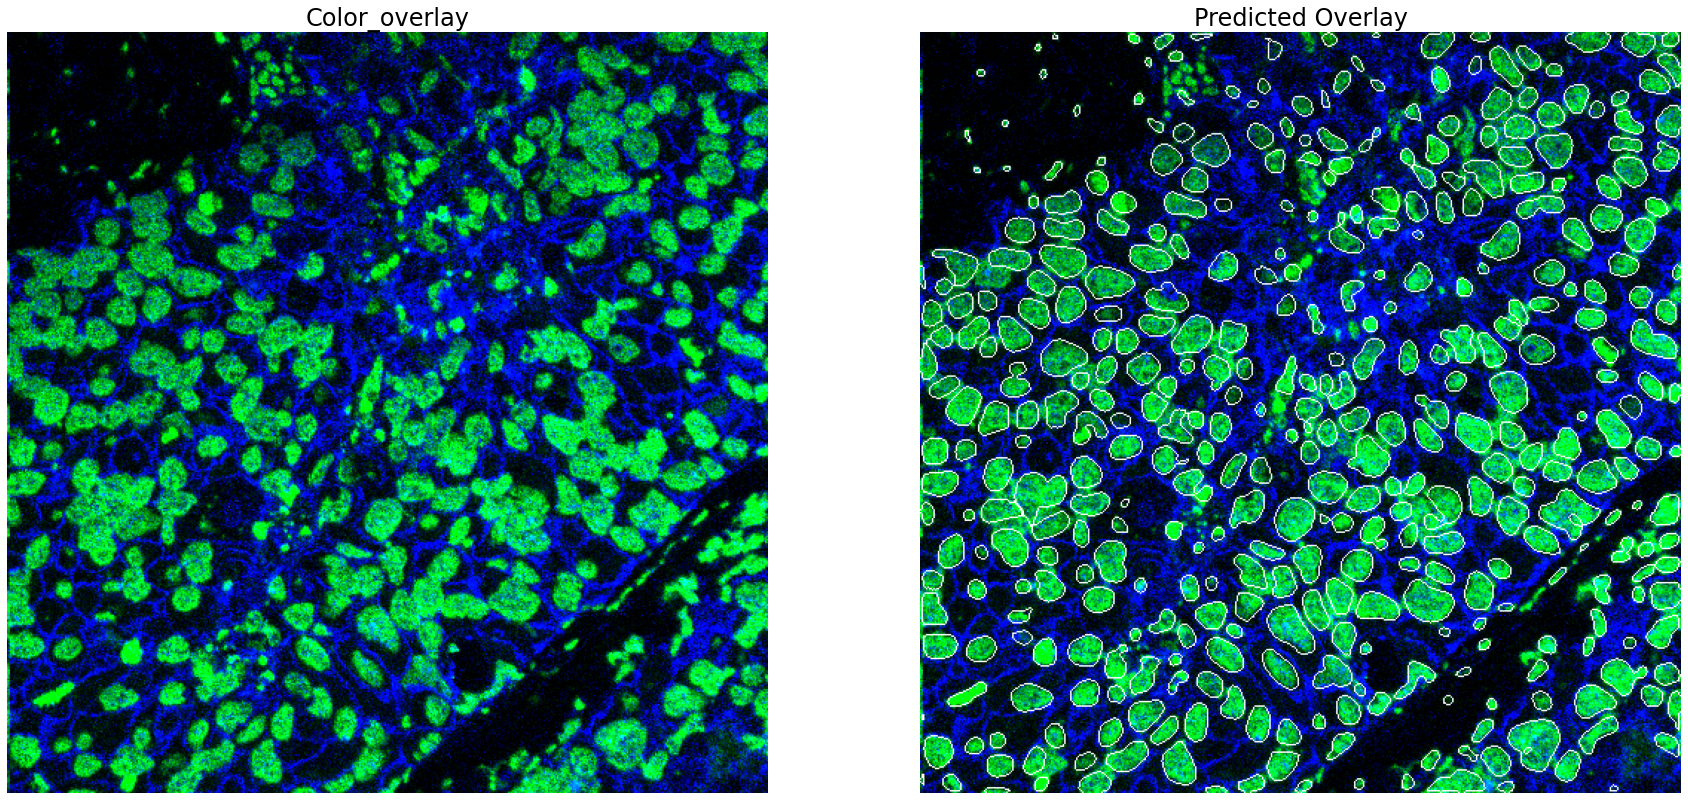

In [42]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = [8]
fig, axes = plt.subplots(1,2,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(RGB_data[index[0],...])
axes[1].imshow(predicted_overlay[index[0], ...], cmap=cmap)

axes[0].set_title('Color_overlay', fontsize=24)
axes[1].set_title('Predicted Overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

In [11]:
predictions = np.concatenate((predictions1, predictions2, predictions3,
                             predictions4, predictions5, predictions6, predictions7), axis=0)

(2546, 512, 512, 1)

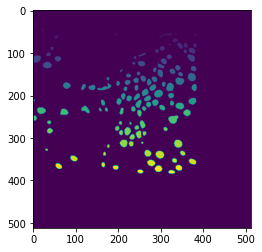

In [14]:
import matplotlib.pyplot as plt
plt.imshow(predictions[1304, :, :, 0])
predictions.shape

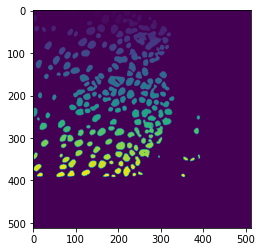

In [20]:
import matplotlib.pyplot as plt
plt.imshow(nuclear_predictions[1404, :, :, 0].astype('float32'))

In [16]:
# set non-nuclear pixels to zero
nuclear_predictions = np.copy(y_data_cell)
for i in range(nuclear_predictions.shape[0]):
    zero_mask = predictions[i, :, :, 0] == 0
    nuclear_predictions[i, zero_mask, 0] = 0

In [17]:
# relabel objects
from skimage.measure import label
for i in range(nuclear_predictions.shape[0]):
    nuclear_predictions[i, ..., 0] = label(nuclear_predictions[i, ..., 0])

In [18]:
# from stray pixels
from skimage.morphology import remove_small_objects
for i in range(nuclear_predictions.shape[0]):
    nuclear_predictions[i, ..., 0] = remove_small_objects(nuclear_predictions[i, ..., 0],
                                                         min_size=6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  """


In [22]:
np.savez_compressed('/data/npz_data/20200816_all_data_normalized_512x512_compartment.npz', 
         X=X_data, 
         y=np.concatenate((y_data_cell, nuclear_predictions), axis=-1))

In [2]:
# create folder for this set of experiments
experiment_folder = "20200619_production_updates"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [3]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200816_all_data_normalized_512x512_compartment"

test_size=0.1
seed=0
DATA_FILE = NPZ_DIR + npz_name + ".npz"
train_dict, val_dict = get_data(DATA_FILE, test_size=test_size, seed=seed)
X_train, y_train = train_dict['X'], train_dict['y']
X_val, y_val = val_dict['X'], val_dict['y']

In [10]:
def find_sparse_images(labeled_data, cutoff=100):
    """Gets coordinates of images that have very few cells
    Args:
        labeled_data: segmentation labels
        cutoff: minimum number of cells per image
    Returns:
        numpy.array: index of images above the threshold
    """

    unique_counts = []
    for img in range(labeled_data.shape[0]):
        unique_counts.append(len(np.unique(labeled_data[img])) - 1)

    unique_counts = np.array(unique_counts)
    idx = unique_counts > cutoff

    return idx

In [11]:
keep_idx = find_sparse_images(y_train[..., :1], 100)

In [12]:
X_train, y_train = X_train[keep_idx], y_train[keep_idx]

In [13]:
keep_idx_val = find_sparse_images(y_val[..., :1], 100)
X_val, y_val = X_val[keep_idx_val], y_val[keep_idx_val]

X.shape: (1210, 512, 512, 2)
y.shape: (1210, 512, 512, 2)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 2

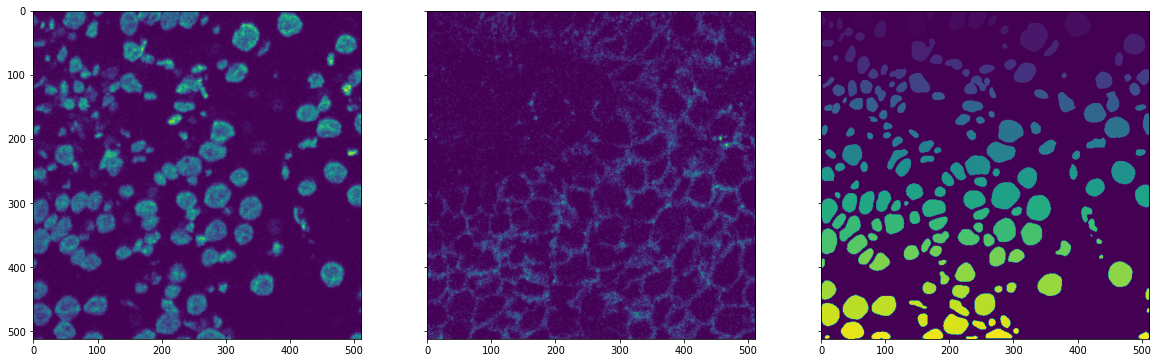

In [14]:
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 20), sharex=True, sharey=True)

idx = 103
axes[0].imshow(X_train[idx,:,:,0].astype('float32'))
axes[1].imshow(X_train[idx,:,:,1].astype('float32'))
axes[2].imshow(y_train[idx,:,:,1])
print(np.unique(y_train[idx]))

In [17]:
k=128
X_train = phase_preprocess(X_train, k)
X_val = phase_preprocess(X_val, k)

In [18]:
from deepcell.model_zoo.panopticnet import PanopticNet

new_model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method=None,
    num_semantic_heads=8,
    num_semantic_classes=[1, 1, 2, 3, 1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

W0817 22:08:19.623905 140548484699968 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [29]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = npz_name + '_deep_watershed'

n_epoch = 50  # Number of training epochs

optimizer = Adam(lr=1e-4, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)

batch_size = 8

min_objects = 20  # throw out images with fewer than this many objects
seed=0
model_name

'20200816_all_data_normalized_512x512_compartment_deep_watershed'

In [20]:
from deepcell import image_generators
from deepcell.utils import train_utils


# use augmentation for training but not validation
datagen = image_generators.CroppingDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(256, 256))

datagen_val = image_generators.CroppingDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0,
    crop_size=(256, 256))
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'pixelwise':{'dilation_radius': 1}, 
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_val, 'y': y_val},
    seed=seed,
    transforms=['inner-distance', 'watershed-cont', 'fgbg', 'pixelwise'],
    transforms_kwargs={'watershed-cont': {'erosion_width': 1}, 'pixelwise':{'dilation_radius': 1},
                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},
    min_objects=min_objects,
    batch_size=batch_size)

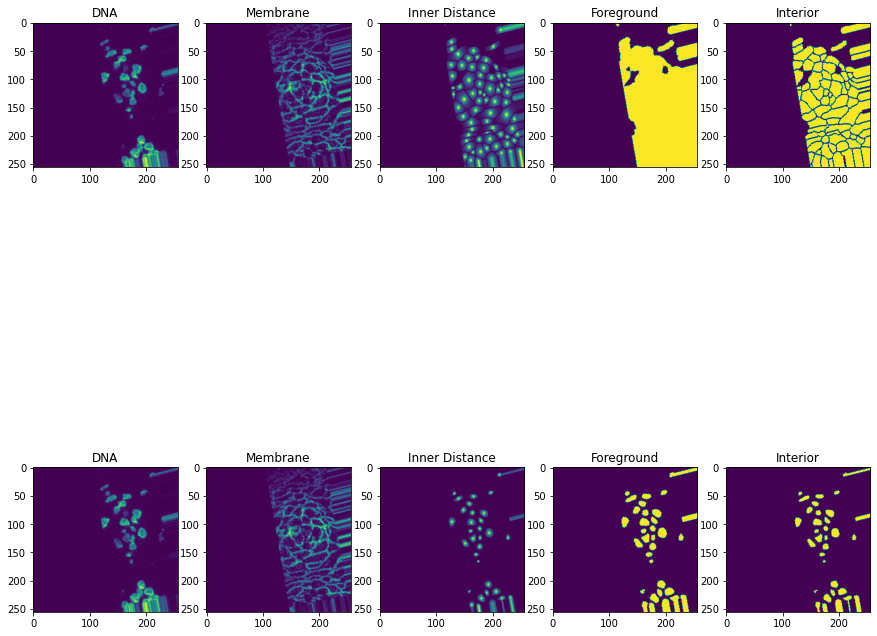

In [25]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]
pixelwise = outputs[3]

inner_distance_nuc = outputs[4]
outer_distance_nuc = outputs[5]
fgbg_nuc = outputs[6]
pixelwise_nuc = outputs[7]

fig, axes = plt.subplots(2, 5, figsize=(15, 15))

axes[0, 0].imshow(img[:, :, 0])
axes[0, 0].set_title('DNA')

axes[0, 1].imshow(img[:, :, 1])
axes[0, 1].set_title('Membrane')

axes[0, 2].imshow(inner_distance[0, ..., 0])
axes[0, 2].set_title('Inner Distance')

axes[0, 3].imshow(fgbg[0, ..., 1])
axes[0, 3].set_title('Foreground')

axes[0, 4].imshow(pixelwise[0, ..., 1])
axes[0, 4].set_title('Interior')

# nuclear
axes[1, 0].imshow(img[:, :, 0])
axes[1, 0].set_title('DNA')

axes[1, 1].imshow(img[:, :, 1])
axes[1, 1].set_title('Membrane')

axes[1, 2].imshow(inner_distance_nuc[0, ..., 0])
axes[1, 2].set_title('Inner Distance')

axes[1, 3].imshow(fgbg_nuc[0, ..., 1])
axes[1, 3].set_title('Foreground')

axes[1, 4].imshow(pixelwise_nuc[0, ..., 1])
axes[1, 4].set_title('Interior')

plt.show()

In [26]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in new_model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [27]:
new_model.compile(loss=loss, optimizer=optimizer)

In [30]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus


model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = new_model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/50
  1/151 [..............................] - ETA: 1:57:15 - loss: 2.0568 - semantic_0_loss: 1.1878 - semantic_1_loss: 0.1966 - semantic_2_loss: 0.0080 - semantic_3_loss: 0.0123 - semantic_4_loss: 0.1222 - semantic_5_loss: 0.5085 - semantic_6_loss: 0.0084 - semantic_7_loss: 0.0129

W0817 22:31:16.428014 140548484699968 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.450160). Check your callbacks.


  2/151 [..............................] - ETA: 59:04 - loss: 1.9378 - semantic_0_loss: 1.1112 - semantic_1_loss: 0.1836 - semantic_2_loss: 0.0076 - semantic_3_loss: 0.0123 - semantic_4_loss: 0.1168 - semantic_5_loss: 0.4852 - semantic_6_loss: 0.0080 - semantic_7_loss: 0.0131  

W0817 22:31:16.716781 140548484699968 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.278328). Check your callbacks.


150/151 [============================>.] - ETA: 0s - loss: 0.2246 - semantic_0_loss: 0.1032 - semantic_1_loss: 0.0431 - semantic_2_loss: 0.0033 - semantic_3_loss: 0.0073 - semantic_4_loss: 0.0166 - semantic_5_loss: 0.0409 - semantic_6_loss: 0.0033 - semantic_7_loss: 0.0070
Epoch 00001: val_loss improved from inf to 0.56581, saving model to /data/models/20200619_production_updates/20200816_all_data_normalized_512x512_compartment_deep_watershed.h5
151/151 [==============================] - 190s 1s/step - loss: 0.2236 - semantic_0_loss: 0.1026 - semantic_1_loss: 0.0430 - semantic_2_loss: 0.0033 - semantic_3_loss: 0.0073 - semantic_4_loss: 0.0165 - semantic_5_loss: 0.0407 - semantic_6_loss: 0.0033 - semantic_7_loss: 0.0070 - val_loss: 0.5658 - val_semantic_0_loss: 0.0556 - val_semantic_1_loss: 0.1124 - val_semantic_2_loss: 0.0784 - val_semantic_3_loss: 0.1023 - val_semantic_4_loss: 0.0318 - val_semantic_5_loss: 0.0559 - val_semantic_6_loss: 0.0499 - val_semantic_7_loss: 0.0795
Epoch 2/50
1

151/151 [==============================] - 77s 508ms/step - loss: 0.0578 - semantic_0_loss: 0.0129 - semantic_1_loss: 0.0205 - semantic_2_loss: 0.0022 - semantic_3_loss: 0.0054 - semantic_4_loss: 0.0053 - semantic_5_loss: 0.0066 - semantic_6_loss: 0.0013 - semantic_7_loss: 0.0037 - val_loss: 0.0575 - val_semantic_0_loss: 0.0121 - val_semantic_1_loss: 0.0193 - val_semantic_2_loss: 0.0022 - val_semantic_3_loss: 0.0052 - val_semantic_4_loss: 0.0055 - val_semantic_5_loss: 0.0071 - val_semantic_6_loss: 0.0017 - val_semantic_7_loss: 0.0044
Epoch 10/50
150/151 [============================>.] - ETA: 0s - loss: 0.0581 - semantic_0_loss: 0.0128 - semantic_1_loss: 0.0206 - semantic_2_loss: 0.0022 - semantic_3_loss: 0.0054 - semantic_4_loss: 0.0053 - semantic_5_loss: 0.0067 - semantic_6_loss: 0.0013 - semantic_7_loss: 0.0037
Epoch 00010: val_loss improved from 0.05749 to 0.05005, saving model to /data/models/20200619_production_updates/20200816_all_data_normalized_512x512_compartment_deep_watersh

150/151 [============================>.] - ETA: 0s - loss: 0.0504 - semantic_0_loss: 0.0114 - semantic_1_loss: 0.0182 - semantic_2_loss: 0.0020 - semantic_3_loss: 0.0051 - semantic_4_loss: 0.0043 - semantic_5_loss: 0.0052 - semantic_6_loss: 0.0011 - semantic_7_loss: 0.0032
Epoch 00027: val_loss did not improve from 0.04607
151/151 [==============================] - 71s 470ms/step - loss: 0.0504 - semantic_0_loss: 0.0114 - semantic_1_loss: 0.0182 - semantic_2_loss: 0.0020 - semantic_3_loss: 0.0051 - semantic_4_loss: 0.0043 - semantic_5_loss: 0.0052 - semantic_6_loss: 0.0011 - semantic_7_loss: 0.0032 - val_loss: 0.0471 - val_semantic_0_loss: 0.0107 - val_semantic_1_loss: 0.0170 - val_semantic_2_loss: 0.0021 - val_semantic_3_loss: 0.0052 - val_semantic_4_loss: 0.0038 - val_semantic_5_loss: 0.0045 - val_semantic_6_loss: 0.0010 - val_semantic_7_loss: 0.0029
Epoch 28/50
150/151 [============================>.] - ETA: 0s - loss: 0.0504 - semantic_0_loss: 0.0113 - semantic_1_loss: 0.0181 - sem

KeyboardInterrupt: 

In [31]:
from deepcell.applications import MultiplexSegmentation
app = MultiplexSegmentation(use_pretrained_weights=False)
app.model.load_weights(os.path.join(MODEL_DIR, model_name + '.h5'))

In [51]:
# labeled_images = app.predict(X_val[:40], postprocess_kwargs_whole_cell={'maxima_threshold': 0.05, 
#                                                                        'maxima_model_smooth': 0,
#                                                                        'interior_model_smooth': 2})
labeled_images = app.predict(X_val[:40], postprocess_kwargs_whole_cell={})

In [33]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img, :, :], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [34]:
RGB_data = make_color_overlay(X_val)
true_overlay = make_outline_overlay(RGB_data, y_val[..., 0])

In [52]:
predicted_overlay = make_outline_overlay(RGB_data[:40], labeled_images[..., 0])

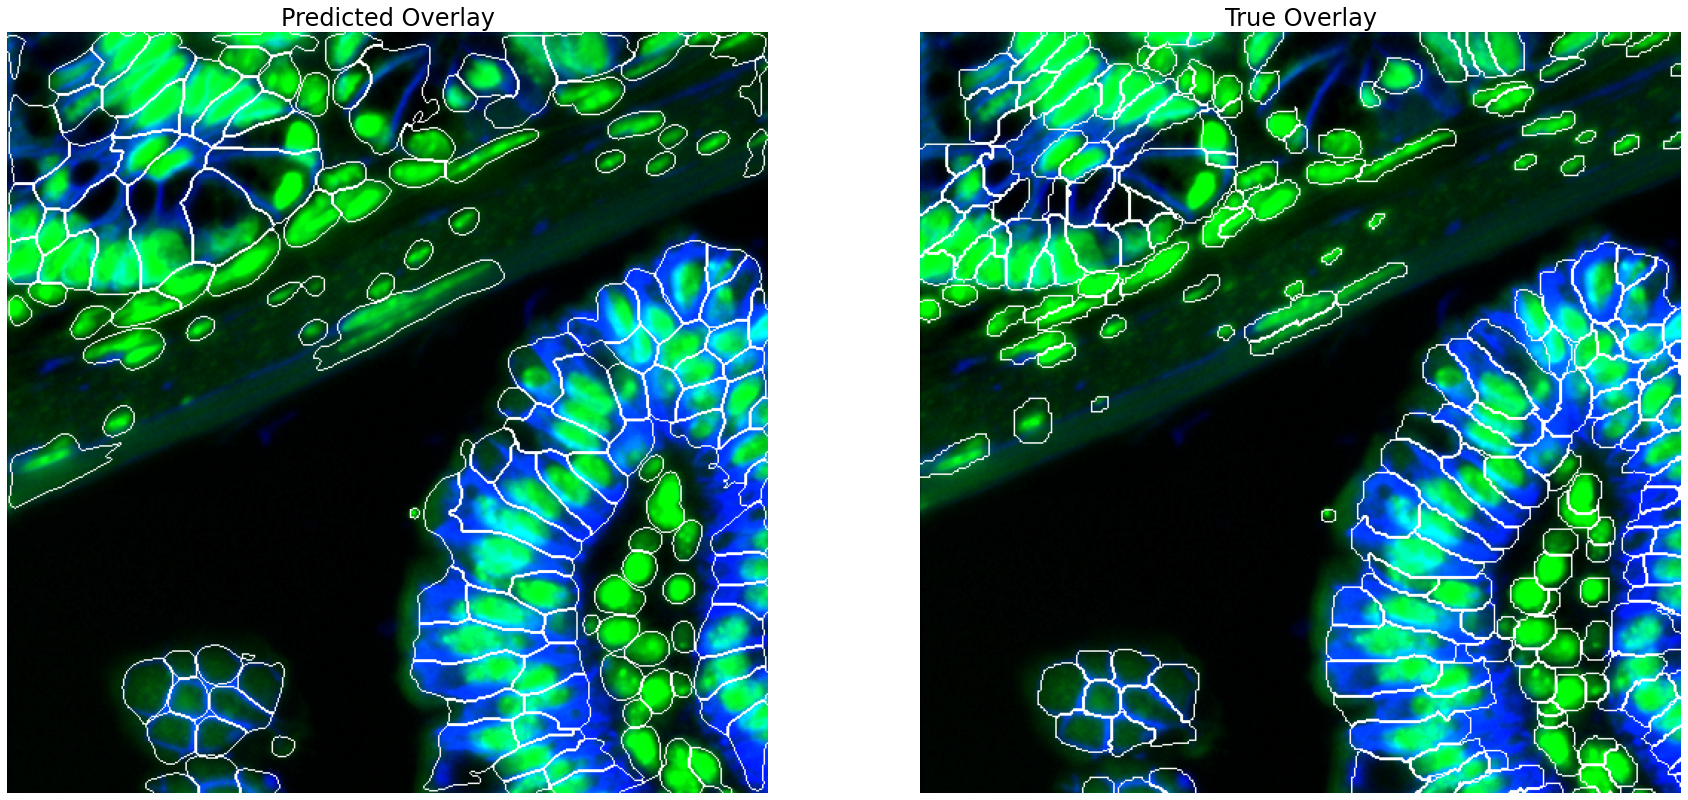

In [56]:
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = [27]
fig, axes = plt.subplots(1,2,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(predicted_overlay[index[0], ...], cmap=cmap)
axes[1].imshow(true_overlay[index[0], ...], cmap=cmap)

axes[0].set_title('Predicted Overlay', fontsize=24)
axes[1].set_title('True Overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()